# An R tutorial on confidence intervals with plots

Here is a *population* of values.  In fact, in our case, it is a complete
collection of the birth weights for all children born in North Carolina in
2008.  See <https://github.com/odsti/datasets/tree/main/birth_weights> for more
on the source of the data.

In [1]:
library(dplyr)
library(glue)
library(ggplot2)
library(cowplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Birth weights for every baby born in North Carolina.
bw_pop <- read.csv('data/nc_birth_weights.csv')
bw_pop_vals <- bw_pop[['birth_weight']]
pop_mean <- mean(bw_pop_vals)

But - we are very rarely in the situation where we know the values for the
entire population.   We are usually in the case where we have some random
sample of values from this population.

So, let's say we are in this typical situation, and we don't know anything
about the underlying population yet.  All we have is a single random sample of
50 values, that someone has taken for us.

In [3]:
# A random sample of birthweights that someone has taken for us.
bw_sample <- read.csv('data/nc_birth_weights_sample.csv')
bw_sample_vals <- bw_sample[['birth_weight']]
sample_mean <- mean(bw_sample_vals)

In [4]:
# The size of our sample(s).
n <- 50

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


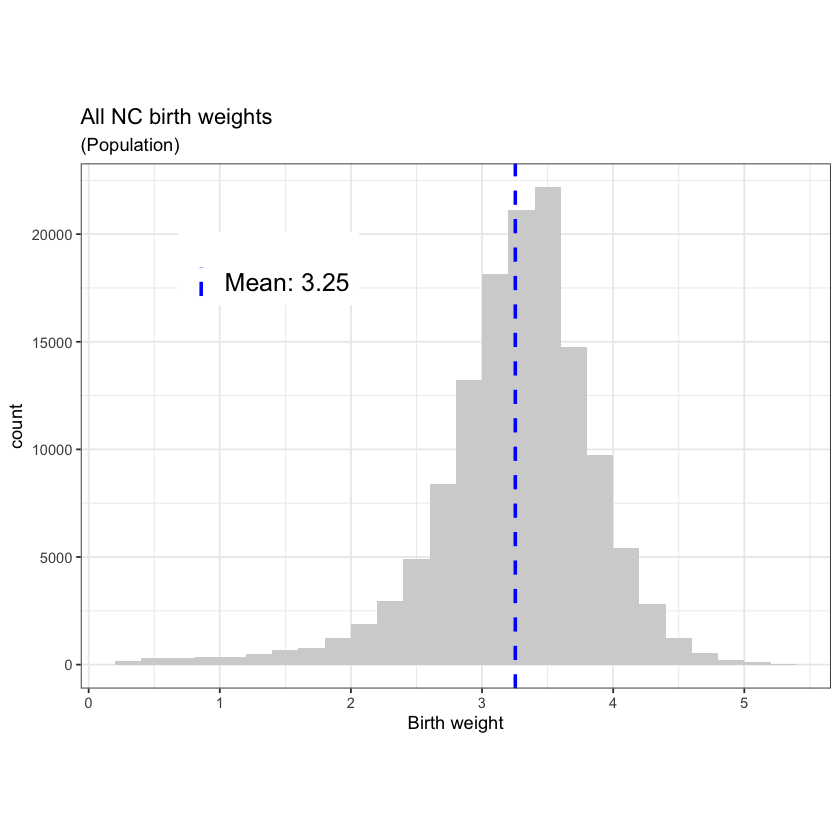

In [5]:
tbw <- theme_set(theme_bw())
breaks <- seq(0.2, 5.5, by=0.2)

plot_bw <- function(df) {
    if (nrow(df) > 1000) {  # Population
        fill_col <- 'light grey'
        mean_col <- 'blue'
    } else {  # Sample
        fill_col <- 'dark grey'
        mean_col <- 'red'
    }
    mean_val <- mean(df[['birth_weight']])
    label <- glue('Mean: {round(mean_val, 2)}')
    p <- (
        ggplot(df, aes(birth_weight))
        + geom_histogram(fill = fill_col, breaks = breaks)
        + geom_vline(aes(xintercept=mean_val, colour=label),
                     linewidth=1,
                     linetype='dashed')
        + labs(x = "Birth weight", colour="")  # Reset colour for later.
        + scale_colour_manual(values=mean_col)
        + theme(legend.position=c(0.25, 0.8),
                legend.text = element_text(size=15),
                aspect.ratio=0.7)
    )
}

pop_p <- plot_bw(bw_pop) + labs(
    title = 'All NC birth weights',
    subtitle = '(Population)')
pop_p

In [6]:
ggsave('population.png', pop_p)

Saving 7 x 7 in image


Note that one can get axis limits like this:

In [7]:
# https://stackoverflow.com/a/62819446
layer_scales(pop_p)$y$get_limits()

[1]     0 22177

Saving 7 x 7 in image


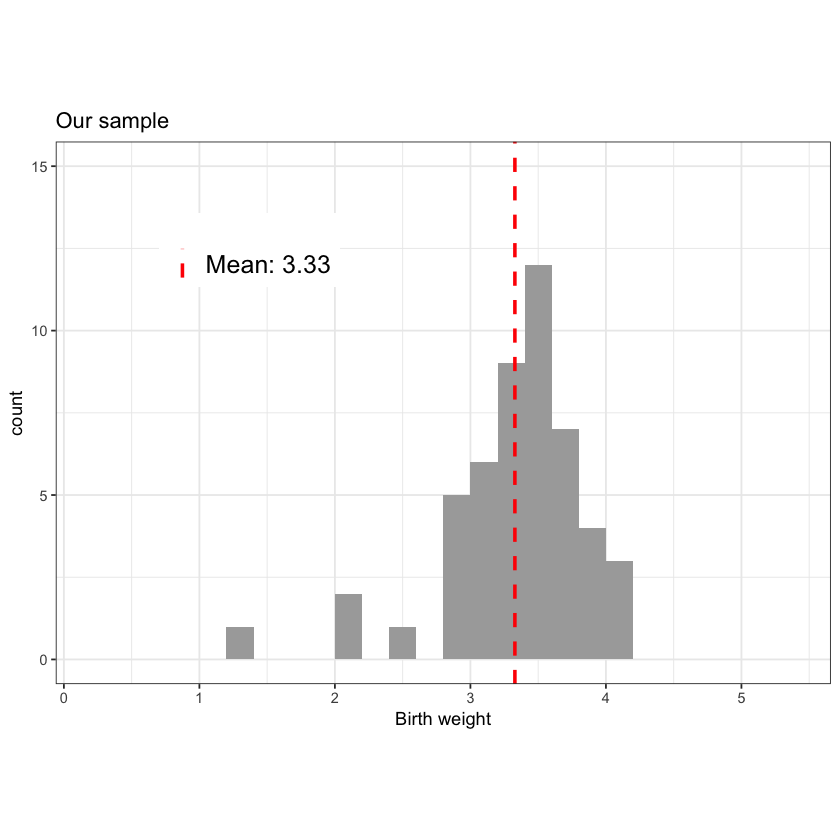

In [8]:
samp_ylims = ylim(0, 15)
p0 <- plot_bw(bw_sample) + labs(
    title = 'Our sample') + samp_ylims
ggsave('our_sample.png', p0)
p0

In [9]:
set.seed(1939)
n <- 50
n_samples <- 5
samples <- list()
for (i in 2:(n_samples + 1)) {
    sample <- sample_n(bw_pop, n)
    name <- sprintf('%d', i)
    p <- (plot_bw(sample)
          + labs(title = glue('Sample {name}'))
          + samp_ylims)
    ggsave(glue('sample{name}.png'), p)
    samples[[name]] = list(sample=sample, plot=p, mean=mean(sample[['birth_weight']]))
}

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


In [10]:
plots = list()
for (name in names(samples)) {
    v <- samples[[name]]
    plots[[name]] <- (v[['plot']]
                    + theme_half_open(12)
                    + theme(legend.position='none')
                    + labs(title=NULL)
                    + xlab(glue('Mean: {round(v[["mean"]], 2)}'))
                    )
}
plots[[1]] <- plots[[1]] + ylab('Counts')

From: <https://wilkelab.org/cowplot/articles/shared_legends.html>

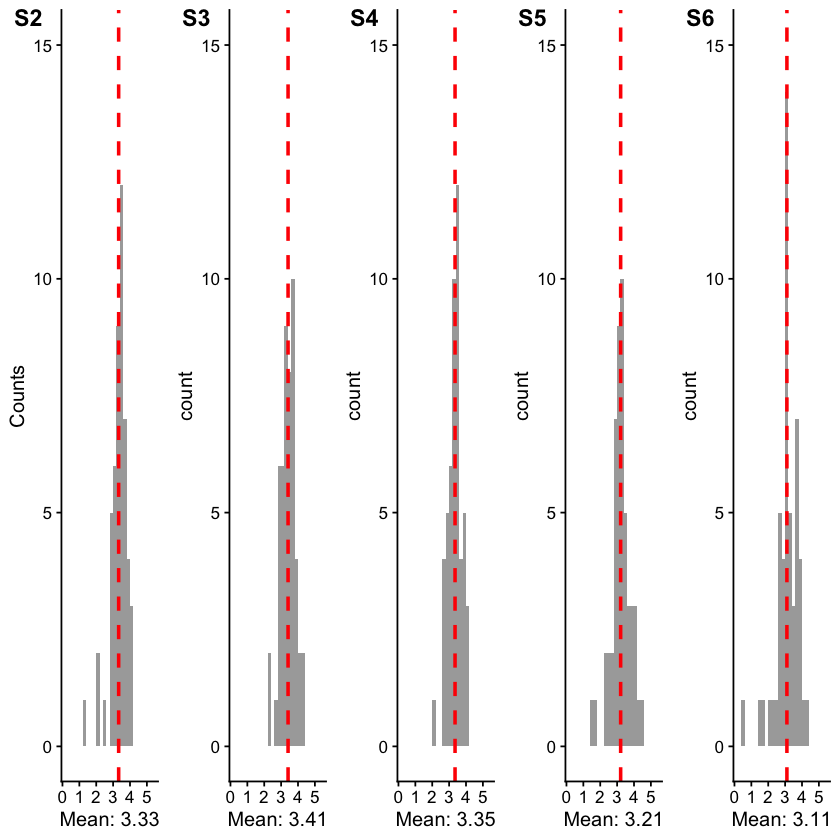

In [11]:
p_samps <- plot_grid(
    plotlist = plots,
    align = 'vh',
    labels = sapply(1:n_samples, function(i) glue('S{i + 1}')),
    nrow = 1
)
p_samps

In [12]:
# https://rdrr.io/cran/cowplot/man/save_plot.html
save_plot('five_samples.png', p_samps, base_asp=4)

In [13]:
# Estimated SD of sampling distribution of mean.
sem <- sd(bw_pop_vals) / sqrt(n)
sem

[1] 0.08740003

In [14]:
samp_lims <- pop_mean + sem * c(-4, 4)
samp_lims

[1] 2.904041 3.603241

In [15]:
samp_dists = list()
means = data.frame(sample_mean=numeric())
samp_breaks = seq(2.9, 3.6, 0.1)
mean_col = 'green'
for (name in names(samples)) {
    means[nrow(means) + 1,] = samples[[name]][['mean']]
    p <- (
        ggplot(means, aes(sample_mean))
        + geom_histogram(breaks = samp_breaks)
        + xlab('Mean birth weight')
        + ylim(0, 5)
        + theme_half_open(12)
        + labs(title=NULL)
    )
    samp_dists[[name]] <- p
}

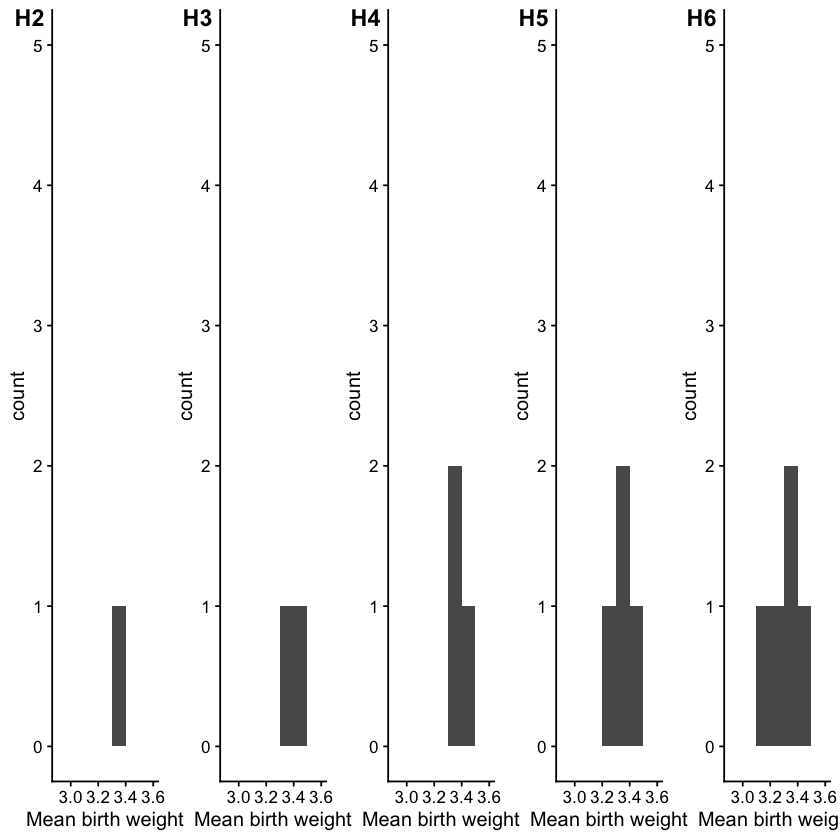

In [16]:
p_mean_dist <- plot_grid(
    plotlist = samp_dists,
    align = 'vh',
    labels = sapply(1:n_samples, function(i) glue('H{i + 1}')),
    nrow = 1
)
p_mean_dist

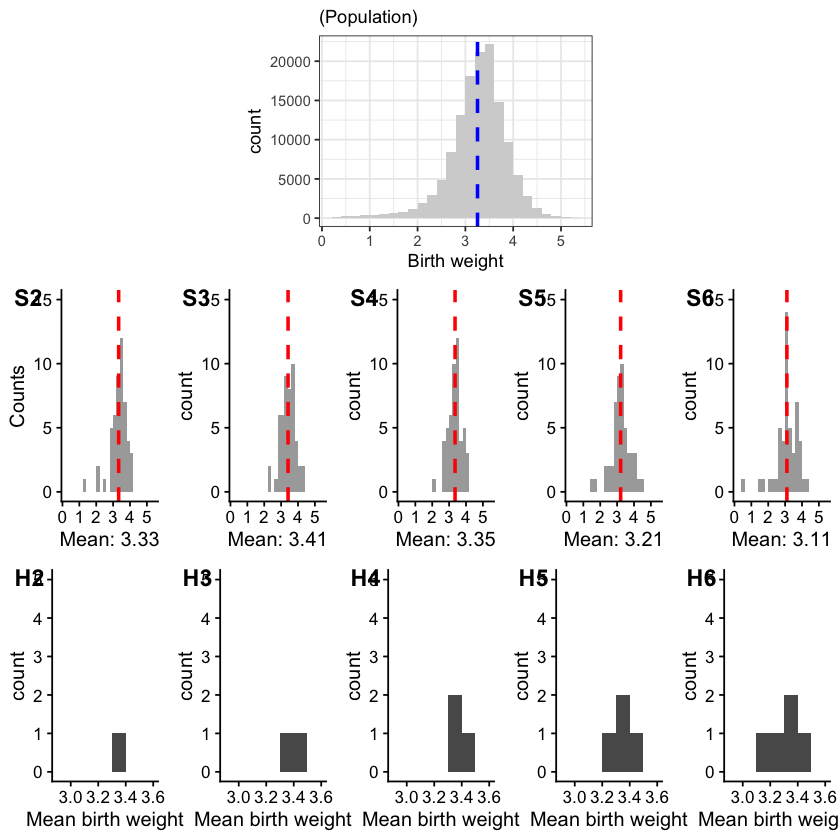

In [17]:
p_whole <- plot_grid(
    pop_p + labs(title=NULL) + theme(legend.position='none'),
    p_samps, p_mean_dist, ncol = 1)
p_whole

In [18]:
save_plot('whole_grid.png', p_whole, base_asp=4)

In [111]:
n_iters <- 10000
samp_dist_vals <- numeric(n_iters)
for (i in 1:n_iters) {
    sample <- sample(bw_pop_vals, n)
    samp_dist_vals[i] <- mean(sample)
}
samp_dist <- data.frame(sample_mean=samp_dist_vals)
m_samp_dist <- mean(samp_dist_vals)

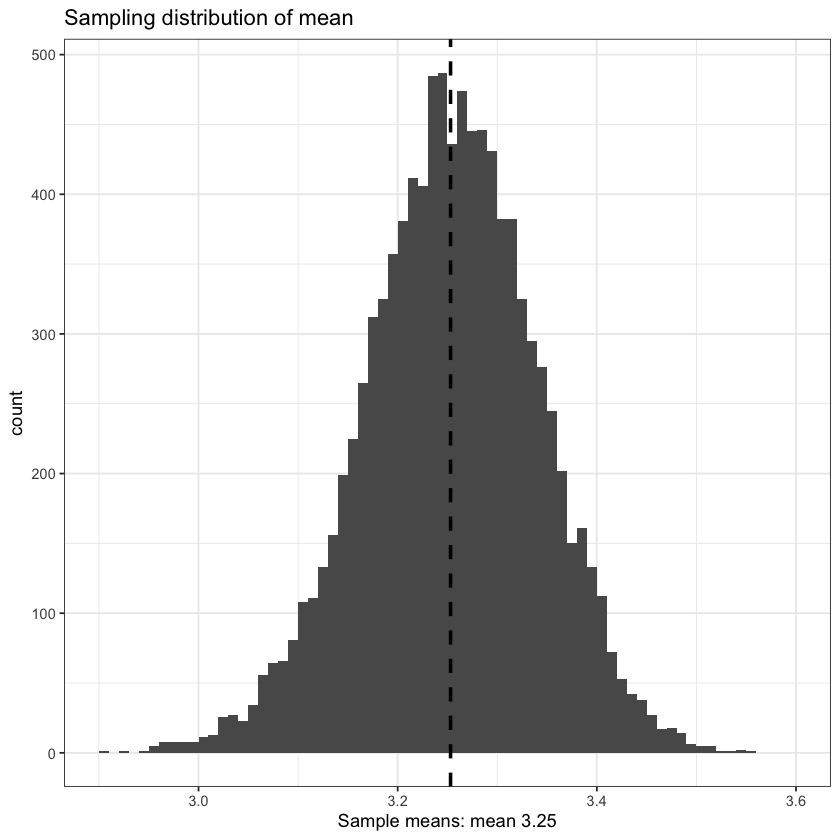

In [20]:
samp_bin_width <- 0.01
full_samp_breaks <- seq(2.9, 3.6, samp_bin_width)
m_s_d <- mean(samp_dist_vals)
x_label <- glue('Sample means: mean {round(m_s_d, 2)}')
p_s_dist <- (
    ggplot(samp_dist, aes(sample_mean))
    + geom_histogram(breaks = full_samp_breaks)
    + geom_vline(aes(xintercept=m_s_d),
                 linewidth=1,
                 linetype='dashed')
    + labs(x = x_label)
    + theme(legend.position='none')
    + labs(title='Sampling distribution of mean')
)
p_s_dist

In [21]:
ggsave('sampling_distribution.png', p_s_dist)

Saving 7 x 7 in image


In [52]:
kde <- density(samp_dist_vals, bw=0.02)
kde_df <- data.frame(x = kde$x, y = kde$y * n_iters * samp_bin_width)
head(kde_df)

,x,y
,<dbl>,<dbl>
1,2.841300,0.002289579
2,2.842822,0.002871572
3,2.844344,0.003574646
4,2.845866,0.004417635
5,2.847388,0.005447336
6,2.848910,0.006699167


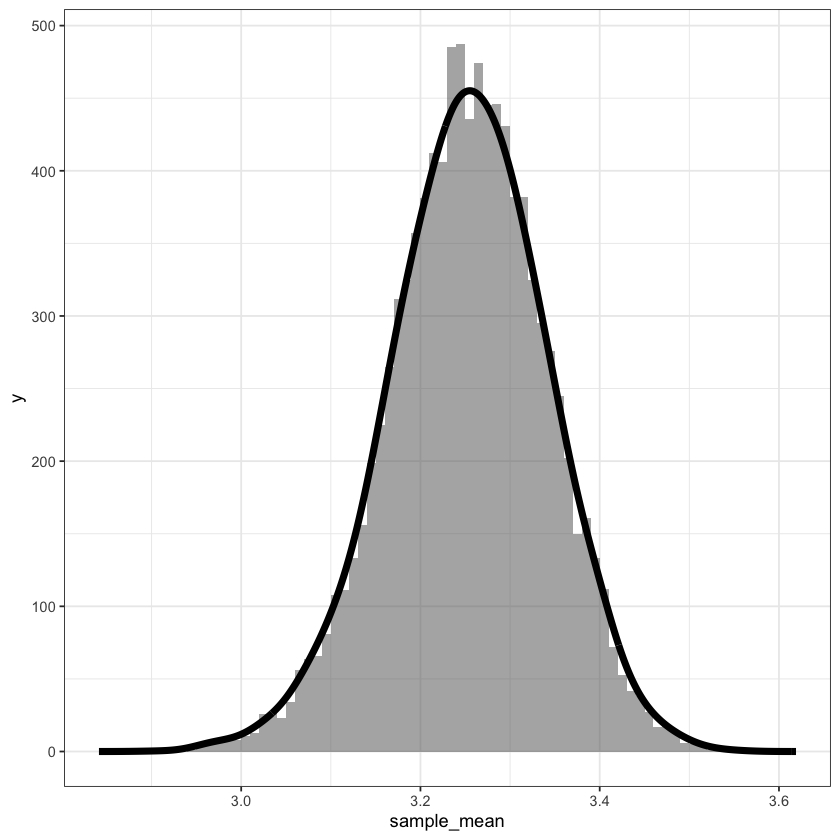

In [61]:
p <- (ggplot(samp_dist, aes(sample_mean))
      + geom_histogram(breaks = full_samp_breaks, alpha=0.5)
      + geom_line(data = kde_df, aes(x = x, y = y),
                  linewidth=2)
      )
p

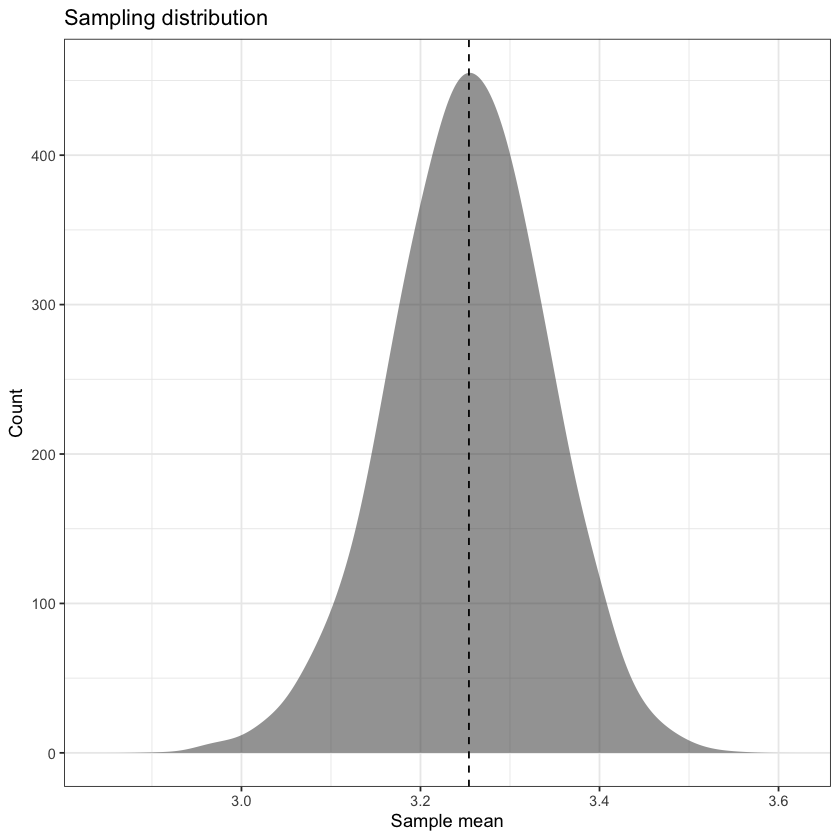

In [133]:
plot_ssamp_dist <- function(df, offset=0) {
    df <- data.table::copy(df)
    df$x <- df$x + offset
    return (
        ggplot(df, aes(df))
        + geom_area(aes(x = x, y = y), linewidth=2, alpha=0.5)
        + labs(x = 'Sample mean', y = 'Count',
               title = 'Sampling distribution')
        + geom_vline(aes(xintercept = m_samp_dist + offset),
                     linetype='dashed')
    )
}

plot_ssamp_dist(kde_df)

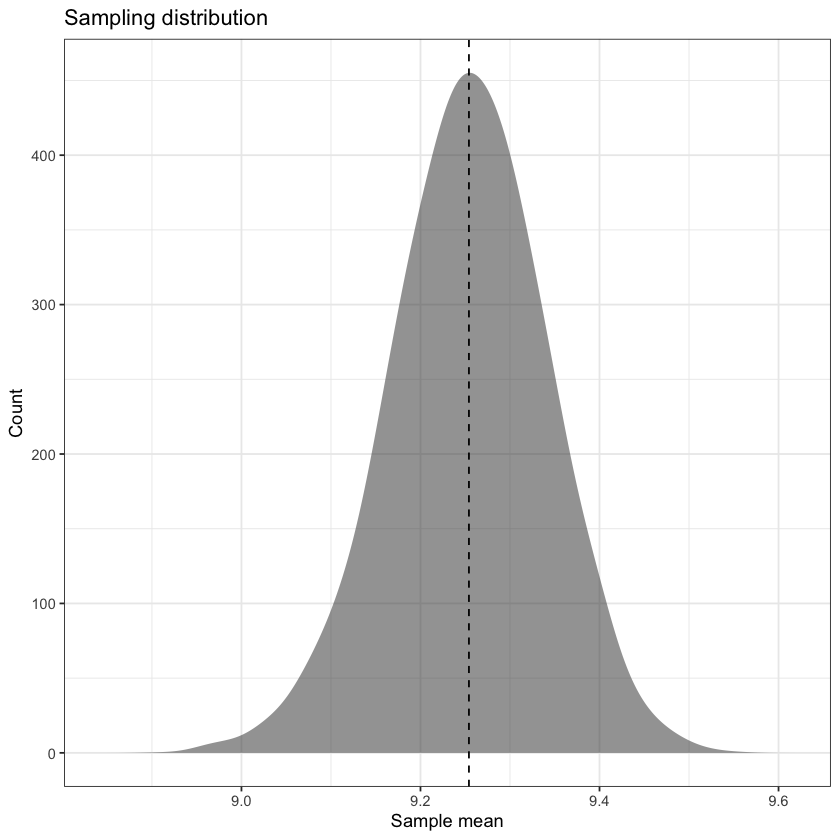

In [129]:
plot_ssamp_dist(kde_df, 6)

In [130]:
kde_cdf <- cumsum(d$y / sum(d$y))
le_025 <- kde_cdf <= 0.025
ge_975 <- kde_cdf >= 0.975
lower_tail <- subset(kde_df, le_025)
upper_tail <- subset(kde_df, ge_975)
lo_025_th <- max(lower_tail$x)
hi_975_th <- min(upper_tail$x)

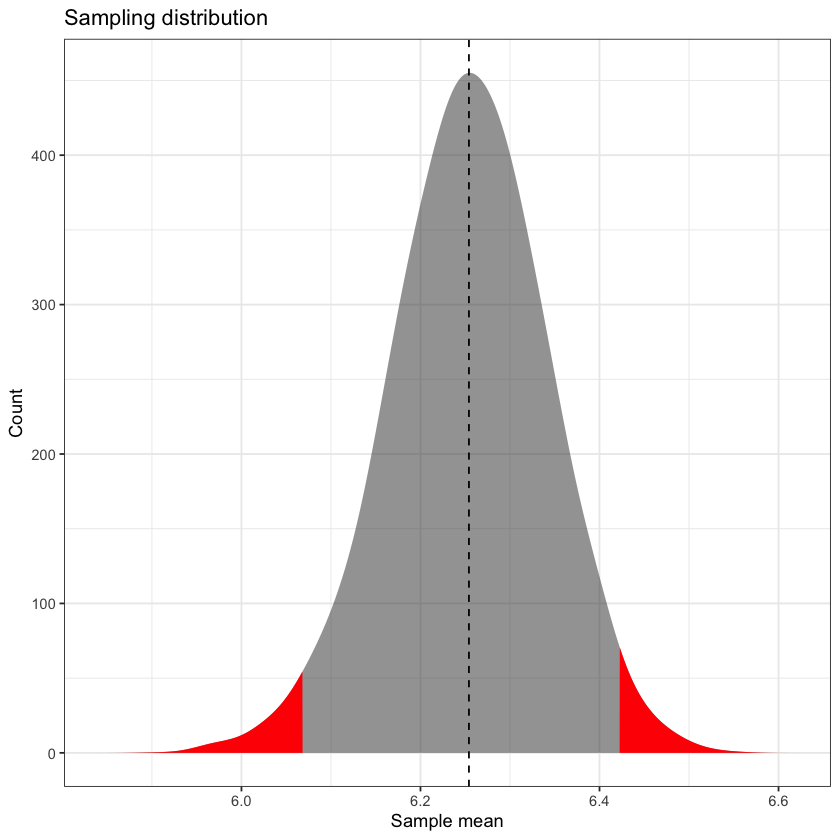

In [135]:
plot_mdist_tails <- function(df, offset=0) {
    p <- plot_ssamp_dist(df, offset)
    lt <- data.table::copy(lower_tail)
    lt$x <- lt$x + offset
    ut <- data.table::copy(upper_tail)
    ut$x <- ut$x + offset
    return (p
            + geom_area(data = lt, aes(x=x, y=y), fill="red")
            + geom_area(data = ut, aes(x=x, y=y), fill="red")
           )
}

plot_mdist_tails(kde_df, 3)

In [121]:
lo_025_th <- max(lower_tail$x)
hi_975_th <- min(upper_tail$x)
upper_diff <- m_samp_dist - lo_025_th
lower_diff <- m_samp_dist - hi_975_th
c(upper_diff, lower_diff)

[1]  0.1860575 -0.1685584

Warning message in geom_segment(aes(x = lo_025_th + e, y = 30, xend = m_samp_dist - :
“All aesthetics have length 1, but the data has 512 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”
Warning message in geom_segment(aes(x = hi_975_th - e, y = 30, xend = m_samp_dist + :
“All aesthetics have length 1, but the data has 512 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”


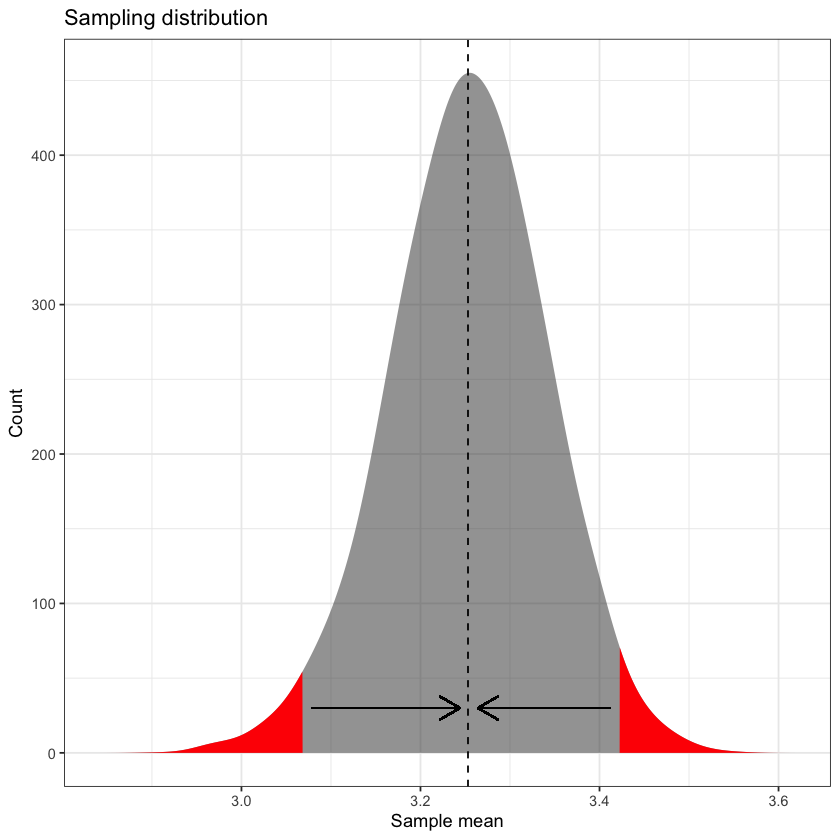

In [125]:
e <- 0.01
(p_tails
 + geom_segment(aes(x = lo_025_th + e, y = 30,
                    xend = m_samp_dist - e, yend = 30),
                arrow = arrow(length = unit(0.5, "cm")))
 + geom_segment(aes(x = hi_975_th - e, y = 30,
                    xend = m_samp_dist + e, yend = 30),
                arrow = arrow(length = unit(0.5, "cm")))
 )

In [173]:
library(animation)

offsets <- sin(seq(0, 2 * pi, 0.05))

min_x <- min(kde$x) - 1
max_x <- max(kde$x) + 1

vid_len <- 10  # Seconds.
fps <- length(offsets) / vid_len

saveVideo(
    {
        ani.options(interval = 1 / fps)
        for (i in 1:length(offsets)) {
            offset <- offsets[i]
            p <- plot_ssamp_dist(kde_df, offset)
            p <- p + xlim(min_x, max_x)
            plot(p)
        }
    },
    video.name = "moving_dist.mp4",
)

Executing: 'ffmpeg' -y -framerate 12.6 -i Rplot%d.png -pix_fmt yuv420p moving_dist.mp4



Video has been created at: /Users/mb312/dev_trees/confidence-intervals/moving_dist.mp4

